Bradley Aherne
117340053

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50, VGG19, EfficientNetB7

# Initialising Directory Structure And Inspecting Data

In [11]:
# WSL is currently unable to avail of GPU accelerated calcutlations :(
base_dir = "." 
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

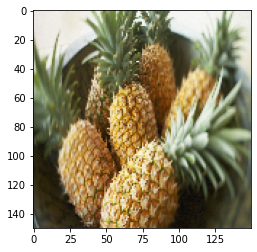

In [12]:
train_pineapple_dir = os.path.join(train_dir, "pineapple")
filenames = [os.path.join(train_pineapple_dir, filename) for filename in os.listdir(train_pineapple_dir)]

idx = 11
some_example = load_img(filenames[idx], target_size=(150,150))

plt.imshow(some_example)

## Data Preprocessing
* Performing preprocessing
     * decode JPEGs to uncompressed grids of RGB integer values (0,255)
     * resize images 150×150 ;
     * encode class labels.

* Stream the data in as batches of 10 to preserve memory by using generators.
* Augemented data is included in the trainind set to increase the number of training samples, I found this improved the results

In [13]:

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

train_generator = train_data_generator.flow_from_directory(
    train_dir, target_size=(244,244), batch_size=10, class_mode="categorical")

# Do not augment the val and test data!
val_data_generator = ImageDataGenerator(rescale=1./255)
val_generator = val_data_generator.flow_from_directory(
    val_dir, target_size=(244,244), batch_size=10, class_mode="categorical")

test_data_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_data_generator.flow_from_directory(
    test_dir, target_size=(244,244), batch_size=10, class_mode="categorical")

BATCH_SIZE = 10
NUM_TRAIN = 150
NUM_TEST = 75
NUM_VAL = 75

Found 150 images belonging to 3 classes.
Found 75 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


In [14]:
def build_convnet():
    network = Sequential()
    network.add(Conv2D(240, (3, 3), activation="relu", input_shape=(244, 244, 3)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(64, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(32, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(512, activation="relu"))
    network.add(Dense(3, activation="softmax"))
    network.compile(optimizer=SGD(lr=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
    return network

In [15]:
convnet = build_convnet()

2022-08-13 18:33:59.744823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-13 18:33:59.744870: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-13 18:33:59.744890: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BradderzXPS9570): /proc/driver/nvidia/version does not exist
2022-08-13 18:33:59.745054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: 

In [16]:
convnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 240)     6720      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 240)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 128)     276608    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [17]:
convnet_history = convnet.fit(train_generator, steps_per_epoch=10, epochs=30, 
                validation_data=val_generator, validation_steps=5,
                callbacks=[EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)],
                verbose=1)
# convnet_history = convnet.fit(train_generator, steps_per_epoch=10, epochs=30, 
#                 validation_data=val_generator, validation_steps=5,
#                 verbose=1)

Epoch 1/30
10/10 [==============================] - 20s 2s/step - loss: 1.0883 - accuracy: 0.3800 - val_loss: 1.0844 - val_accuracy: 0.3400
Epoch 2/30
10/10 [==============================] - 20s 2s/step - loss: 1.0749 - accuracy: 0.3900 - val_loss: 1.0418 - val_accuracy: 0.5600
Epoch 3/30
10/10 [==============================] - 19s 2s/step - loss: 1.0496 - accuracy: 0.4200 - val_loss: 0.9892 - val_accuracy: 0.5800
Epoch 4/30
10/10 [==============================] - 21s 2s/step - loss: 1.0346 - accuracy: 0.5100 - val_loss: 0.9735 - val_accuracy: 0.6200
Epoch 5/30
10/10 [==============================] - 21s 2s/step - loss: 0.9437 - accuracy: 0.5600 - val_loss: 0.8886 - val_accuracy: 0.6600
Epoch 6/30
10/10 [==============================] - 25s 3s/step - loss: 0.9021 - accuracy: 0.6400 - val_loss: 0.6383 - val_accuracy: 0.7600
Epoch 7/30
10/10 [==============================] - 23s 2s/step - loss: 0.8619 - accuracy: 0.5900 - val_loss: 0.6978 - val_accuracy: 0.6600
Epoch 8/30
10/10 [==

> Just by using the bare minimum here we can see that the network performs quite well.

<AxesSubplot:>

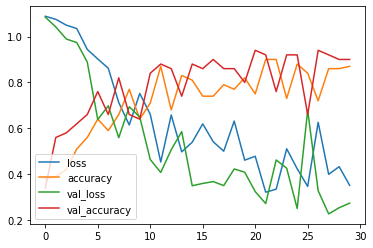

In [18]:
pd.DataFrame(convnet_history.history).plot()

In [ ]:
path = os.path.join(base_dir, "/val/tangerine")
pathnames = [os.path.join(path, filename) for filename in sorted(os.listdir(path))]

imgs = [load_img(img_path, target_size=(244, 244)) for img_path in pathnames]

img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor /= 255

with np.printoptions(precision=15, suppress=True):
    print(convnet.predict(img_tensor))

# Adding in Pretrained layer
* ResNet50
     * As expected this performed slightly worse. Looking at Imagenet perofrmance CGG16  
* VGG16

In [21]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(244, 244, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [22]:
def build_transfer_convnet():
    network = Sequential()
    network.add(resnet50_base)
    resnet50_base.trainable = False
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(Conv2D(32, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(512, activation="relu"))
    network.add(Dense(3, activation="softmax"))
    network.compile(optimizer=SGD(lr=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
    return network

In [23]:
transfer_res_convnet = build_transfer_convnet()

In [24]:
transfer_res_convnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 128)         2359424   
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 32)          36896     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                      

In [28]:
convnet_history = transfer_res_convnet.fit(train_generator, steps_per_epoch=10, epochs=30, 
                validation_data=val_generator, validation_steps=5,
                callbacks=[EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)],
                verbose=1)

Epoch 1/30
10/10 [==============================] - 9s 856ms/step - loss: 1.1174 - accuracy: 0.3200 - val_loss: 1.0978 - val_accuracy: 0.3600
Epoch 2/30
10/10 [==============================] - 8s 842ms/step - loss: 1.0984 - accuracy: 0.3300 - val_loss: 1.0976 - val_accuracy: 0.3200
Epoch 3/30
10/10 [==============================] - 9s 948ms/step - loss: 1.0992 - accuracy: 0.3400 - val_loss: 1.1009 - val_accuracy: 0.3000
Epoch 4/30
10/10 [==============================] - 10s 989ms/step - loss: 1.0993 - accuracy: 0.3400 - val_loss: 1.0995 - val_accuracy: 0.2800
Epoch 5/30
10/10 [==============================] - 9s 956ms/step - loss: 1.0995 - accuracy: 0.3000 - val_loss: 1.0984 - val_accuracy: 0.3600
Epoch 6/30
10/10 [==============================] - 9s 954ms/step - loss: 1.0991 - accuracy: 0.3500 - val_loss: 1.0985 - val_accuracy: 0.3400
Epoch 7/30
10/10 [==============================] - 9s 953ms/step - loss: 1.0992 - accuracy: 0.3200 - val_loss: 1.0996 - val_accuracy: 0.2400
Epoch

<AxesSubplot:>

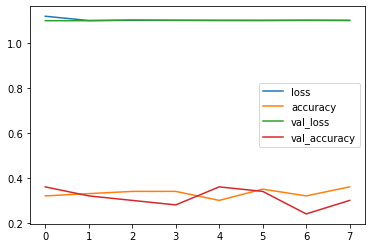

In [29]:
pd.DataFrame(convnet_history.history).plot()

In [30]:
path = os.path.join(base_dir, "/val/tangerine")
pathnames = [os.path.join(path, filename) for filename in sorted(os.listdir(path))]

imgs = [load_img(img_path, target_size=(244, 244)) for img_path in pathnames]

img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor /= 255

with np.printoptions(precision=15, suppress=True):
    print(transfer_res_convnet.predict(img_tensor))

1/1 [==============================] - 2s 2s/step
[[0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493403 0.3373589 ]
 [0.32770708 0.33493406 0.3373589 ]]


# Trying VGG16/VGG19
    * Using VGG19 seemed to have more consistent accuracies with lower losses. The deeper layer may be better suited to this task.
  

In [31]:
VGG19_base = VGG19(weights="imagenet", include_top=False, input_shape=(244, 244, 3))

80134624/80134624 [==============================] - 3s 0us/step


In [32]:
def build_transfer_vg_convnet():
    network = Sequential()
    network.add(VGG19_base);
    VGG19_base.trainable = False
    network.add(Conv2D(64, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(512, activation="relu"))
    network.add(Dense(3, activation="softmax"))
    network.compile(optimizer=SGD(lr=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
    return network

In [33]:
transfer_vg_convnet = build_transfer_vg_convnet()

Freezing the values of the lower layers to train the upper layers, then with a lower learning rate retraining the whole network to fine tune. The performance from this method is providing an accuracy of 1 and extremely low losses so it is probably unnecessary to go layer by layer and tune those individually.

In [34]:
convnet_history1 = transfer_vg_convnet.fit(train_generator, steps_per_epoch=10, epochs=40, 
                validation_data=val_generator, validation_steps=5,
                callbacks=[EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)],
                verbose=1)
VGG19_base.trainable = True
transfer_vg_convnet.compile(optimizer=SGD(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
convnet_history2 = transfer_vg_convnet.fit(train_generator, steps_per_epoch=10, epochs=40, 
                validation_data=val_generator, validation_steps=5,
                callbacks=[EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)],
                verbose=1)

Epoch 1/40
10/10 [==============================] - 27s 3s/step - loss: 1.1004 - accuracy: 0.4700 - val_loss: 0.9168 - val_accuracy: 0.7200
Epoch 2/40
10/10 [==============================] - 27s 3s/step - loss: 0.9327 - accuracy: 0.5700 - val_loss: 0.7232 - val_accuracy: 0.7000
Epoch 3/40
10/10 [==============================] - 27s 3s/step - loss: 0.7792 - accuracy: 0.7100 - val_loss: 0.4356 - val_accuracy: 0.9800
Epoch 4/40
10/10 [==============================] - 28s 3s/step - loss: 0.7147 - accuracy: 0.7400 - val_loss: 0.4386 - val_accuracy: 0.8400
Epoch 5/40
10/10 [==============================] - 27s 3s/step - loss: 0.5912 - accuracy: 0.8000 - val_loss: 0.2937 - val_accuracy: 0.9800
Epoch 6/40
10/10 [==============================] - 29s 3s/step - loss: 0.6507 - accuracy: 0.7200 - val_loss: 0.2745 - val_accuracy: 0.9600
Epoch 7/40
10/10 [==============================] - 27s 3s/step - loss: 0.3298 - accuracy: 0.8800 - val_loss: 0.1779 - val_accuracy: 0.9400
Epoch 8/40
10/10 [==

10/10 [==============================] - 72s 7s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 29/40
10/10 [==============================] - 73s 7s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000


In [35]:
transfer_vg_convnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 64)          294976    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                      

### Analysis of VGG16(19)
Looking at the below results we can see that the model seems to be relatively well fitted with incredibly high accuracy and low losses. This leads me to believe that trying a deeper network such as VGG19 may lead to slightly more overfitting 

<AxesSubplot:>

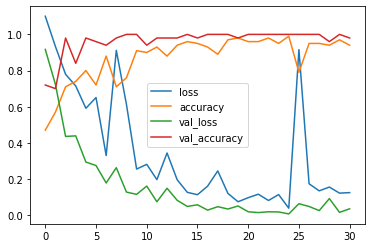

In [36]:
pd.DataFrame(convnet_history1.history).plot()

<AxesSubplot:>

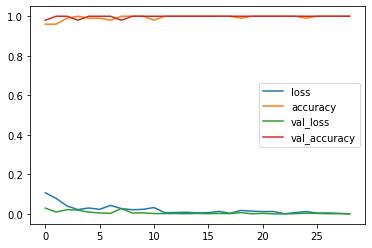

In [37]:
pd.DataFrame(convnet_history2.history).plot()

/tmp/ipykernel_27504/2928233710.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


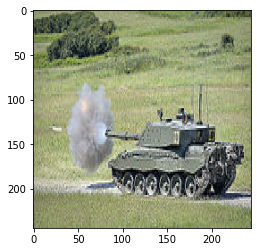

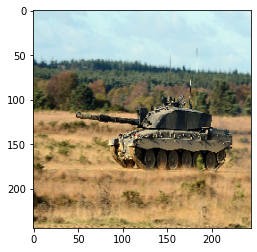

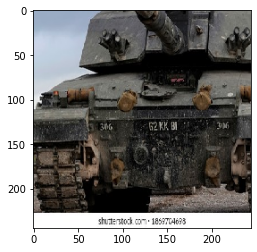

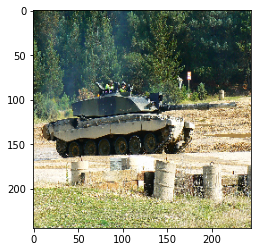

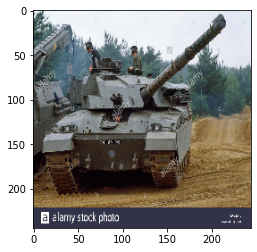

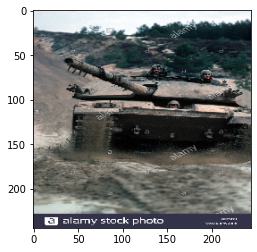

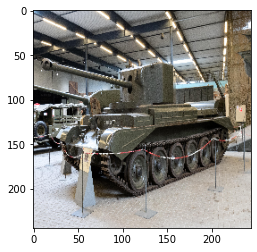

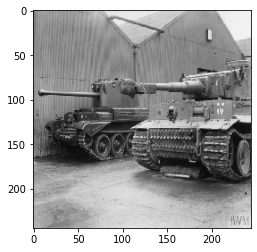

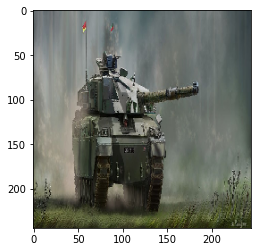

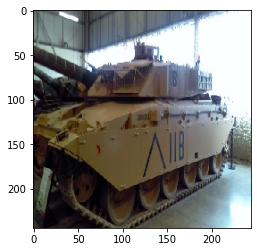

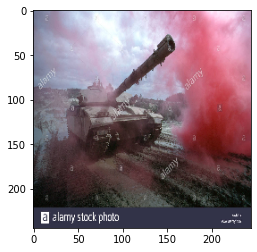

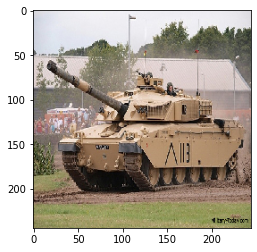

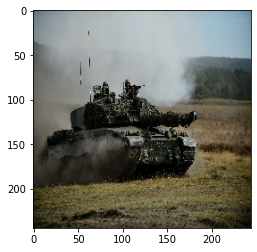

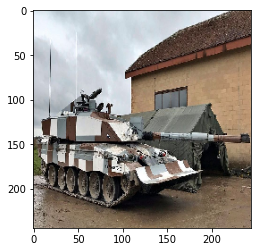

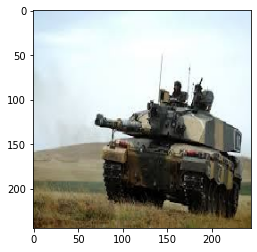

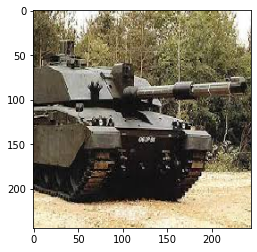

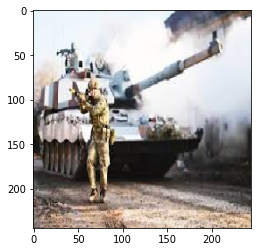

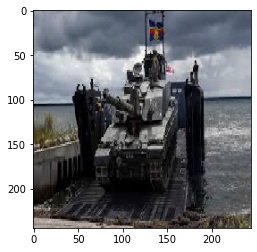

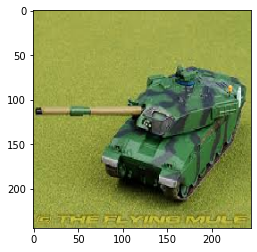

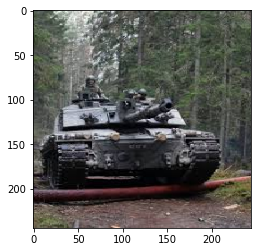

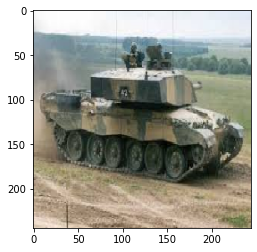

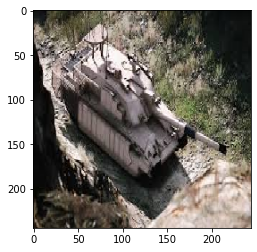

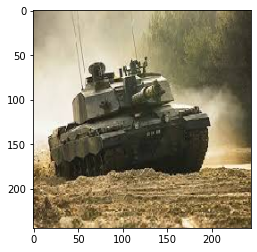

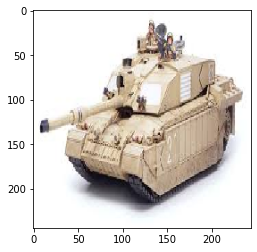

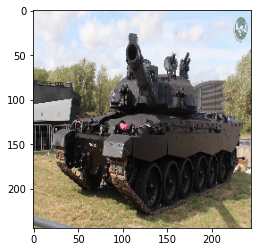

In [39]:
path = os.path.join(base_dir, "/val/challengertank")
pathnames = [os.path.join(path, filename) for filename in sorted(os.listdir(path))]

imgs = [load_img(img_path, target_size=(244, 244)) for img_path in pathnames]
for img in imgs:
    plt.figure()
    plt.imshow(img)

In [40]:
img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor /= 255

In [41]:
with np.printoptions(precision=15, suppress=True):
    print(transfer_vg_convnet.predict(img_tensor))

1/1 [==============================] - 3s 3s/step
[[0.9993296         0.00065625005     0.000014022602   ]
 [0.99994785        0.00005141834     0.00000076515323 ]
 [0.9983641         0.00076178875     0.0008740584     ]
 [0.9999252         0.000062738814    0.00001207874    ]
 [0.9999948         0.0000049496743   0.00000016324168 ]
 [0.99993247        0.00006470756     0.0000027638232  ]
 [0.99994713        0.000050809234    0.0000020621783  ]
 [0.9997952         0.00020161219     0.0000031388847  ]
 [0.9999873         0.000012349577    0.00000026537433 ]
 [0.9999822         0.000016609134    0.0000011839652  ]
 [0.9988681         0.0011211511      0.000010710603   ]
 [0.99999684        0.0000030317412   0.00000008272166 ]
 [0.9999625         0.00003654072     0.0000008370286  ]
 [0.9999891         0.000010717368    0.00000014858563 ]
 [0.9999829         0.000016896289    0.00000006622559 ]
 [0.9999886         0.000010366427    0.0000009221862  ]
 [0.9964286         0.0035707152      

In [42]:
transfer_vg_convnet.save("best_network.h5")

# Current best imagenet classifiers
    we see they use multiple different bases but many of the top ones use EfficientNet, In my case I probably do not need to use sequential layers as theres is not multiple tasks to be done here. We can also see that the accuracy and errors here are quite good.

Epoch 1/40
10/10 [==============================] - 42s 3s/step - loss: 20.1836 - accuracy: 0.3500 - val_loss: 9.6795 - val_accuracy: 0.3000
Epoch 2/40
10/10 [==============================] - 24s 2s/step - loss: 3.2578 - accuracy: 0.3100 - val_loss: 1.1055 - val_accuracy: 0.3800
Epoch 3/40
10/10 [==============================] - 25s 3s/step - loss: 1.2224 - accuracy: 0.3100 - val_loss: 1.1209 - val_accuracy: 0.4200
Epoch 4/40
10/10 [==============================] - 26s 3s/step - loss: 1.2083 - accuracy: 0.3600 - val_loss: 1.1801 - val_accuracy: 0.3000
Epoch 5/40
10/10 [==============================] - 26s 3s/step - loss: 1.1552 - accuracy: 0.3000 - val_loss: 1.1322 - val_accuracy: 0.2800
Epoch 6/40
10/10 [==============================] - 26s 3s/step - loss: 1.1373 - accuracy: 0.4100 - val_loss: 1.0942 - val_accuracy: 0.3800
Epoch 7/40
10/10 [==============================] - 27s 3s/step - loss: 1.1192 - accuracy: 0.3000 - val_loss: 1.1088 - val_accuracy: 0.4200
Epoch 8/40
10/10 [=

<AxesSubplot:>

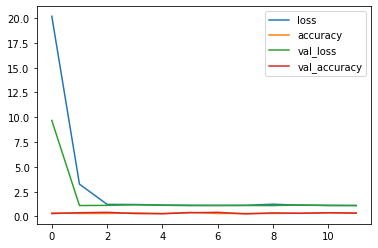

In [44]:
EfficientNetB7_base = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(244, 244, 3))

def build_transfer_en_convnet():  
    # Model layers
    network = Sequential()
    network.add(EfficientNetB7_base);
    EfficientNetB7_base.trainable = False
    network.add(Conv2D(64, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(512, activation="relu"))
    network.add(Dense(3, activation="softmax"))
    network.compile(optimizer=SGD(lr=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
    return network

transfer_en_convnet = build_transfer_en_convnet()

convnet_history = transfer_en_convnet.fit(train_generator, steps_per_epoch=10, epochs=40, 
            validation_data=val_generator, validation_steps=5,
            callbacks=[EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)],
                                                          verbose=1)
pd.DataFrame(convnet_history.history).plot()

In [46]:
path = os.path.join(base_dir, "/val/challengertank")
pathnames = [os.path.join(path, filename) for filename in sorted(os.listdir(path))]

imgs = [load_img(img_path, target_size=(244, 244)) for img_path in pathnames]

img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor /= 255

with np.printoptions(precision=15, suppress=True):
    print(transfer_en_convnet.predict(img_tensor))

1/1 [==============================] - 8s 8s/step
[[0.28619137 0.4104564  0.3033522 ]
 [0.28769824 0.41234827 0.29995346]
 [0.28650996 0.41247636 0.30101377]
 [0.2870759  0.41197062 0.30095354]
 [0.28783187 0.41041175 0.3017563 ]
 [0.28671923 0.41215032 0.30113056]
 [0.28572282 0.41308177 0.30119532]
 [0.28770545 0.41123387 0.30106044]
 [0.28802875 0.40967196 0.30229926]
 [0.2867483  0.40945792 0.30379373]
 [0.28867418 0.4090711  0.30225486]
 [0.2877416  0.41141748 0.30084085]
 [0.2876214  0.41028085 0.3020977 ]
 [0.28717428 0.41114634 0.30167937]
 [0.28638384 0.41277447 0.30084163]
 [0.28612655 0.4124121  0.30146122]
 [0.28666714 0.41207695 0.30125585]
 [0.2885889  0.40804496 0.30336607]
 [0.28788203 0.40996942 0.30214852]
 [0.28728488 0.41007137 0.30264372]
 [0.2883306  0.41079766 0.30087176]
 [0.28709286 0.4142734  0.29863375]
 [0.28832048 0.4114086  0.30027083]
 [0.28803256 0.4092474  0.30272   ]
 [0.288715   0.40901834 0.3022667 ]]


In [ ]:
EfficientNetB7_base = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(244, 244, 3))
VGG19_base = VGG19(weights="imagenet", include_top=False, input_shape=(244, 244, 3))

def sequential_en_network():
    class_output = Dense(3, activation="softmax")(VGG19_base.output)
    x = GlobalMaxPooling2D()(EfficientNetB7_base.output)
    x = BatchNormalization()(x)
    loc_output = Dense(3, activation="linear")(x)
    model = Model(inputs=[EfficientNetB7_base.inputs, VGG19_base.inputs],
                  outputs=[class_output, loc_output])

    model.compile(optimizer=Adam(lr=0.0004),
              loss=["categorical_cross_entropy"],
              loss_weights=[0.7, 0.3])
    return model

en_network = sequential_en_network()

convnet_history = en_network.fit(train_generator, steps_per_epoch=10, epochs=40, 
            validation_data=val_generator, validation_steps=5,
            callbacks=[EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)],
                                                          verbose=1)

path = os.path.join(base_dir, "/val/challengertank")
pathnames = [os.path.join(path, filename) for filename in sorted(os.listdir(path))]

imgs = [load_img(img_path, target_size=(244, 244)) for img_path in pathnames]

img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor /= 255

with np.printoptions(precision=15, suppress=True):
    print(en_network.predict(img_tensor))
    
pd.DataFrame(convnet_history.history).plot()

Running the above cell tends to return an OOM error for me. The intention was to test efficientnet and VGG16 seperately and then try to combine them together in a sequential model. Some of the best performing classifiers on the imagenet set seem to be multiple bases retrained and working together to provide the ebst performance.

# Testing the models

In [ ]:
test_loss, test_acc = transfer_vg_convnet.evaluate(test_generator)
test_acc

In [ ]:
test_loss, test_acc = transfer_res_convnet.evaluate(test_generator)
test_acc

In [ ]:
test_loss, test_acc = convnet.evaluate(test_generator)
test_acc

In [ ]:
import matplotlib.pyplot as plt
from math import factorial as fact

def getY(k , n=2**10):
    total = (fact(n) / (fact(k-1)*fact(n-(k-1))) ) / (fact(k+(n-1)) / (fact(k-1)*fact(n-(k+(n-1)))) )
    
    ()
    return total


x = [i for i in range(2, 2**10)]
y = [getY(i) for i in range(0, 2**10)]

plt.plot(x, y)

In [ ]:
print(y[10:])